In [168]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Encoder & Decoder of genetic circuits

In this notebook, we will construct an encoder-decoder to create a representation space that correlates with topologies or motifs in a genetic circuit.

Inspired by [Generative aptamer discovery using RaptGen](https://www.nature.com/articles/s43588-022-00249-6#Fig1).

## Imports

In [169]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.data.data_format_tools.common import write_json
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from typing import List
from functools import partial

import os
import sys
import numpy as np
import haiku as hk
import jax
import jax.numpy as jnp
import equinox as eqx
import optax  # https://github.com/deepmind/optax
from jaxtyping import Array, Float, Int  # https://github.com/google/jaxtyping

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import r2_score  
                
import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


jax.devices()

[gpu(id=0)]

In [170]:
from src.models.mlp import MLP, MLP_fn
from src.losses.losses import loss_fn, compute_accuracy_categorical, compute_accuracy_regression
from src.utils.math import custom_round, convert_to_scientific_exponent
from src.utils.data_preprocessing import drop_duplicates_keep_first_n

## Load data

In [171]:
fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
fn_test_data = '../data/raw/ensemble_mutation_effect_analysis/2023_10_03_204819/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
try:
    data.drop(columns=['Unnamed: 0'], inplace=True)
except:
    pass

# Encoder

We will use a simple MLP for the encoder and decoder. There are several options for the head, but for now, we will use regression.

## Hyperparameters

In [182]:
BATCH_SIZE = 128
N_BATCHES = 1200
TOTAL_DS = BATCH_SIZE * N_BATCHES
MAX_TOTAL_DS = TOTAL_DS
TRAIN_SPLIT = 0.8
LEARNING_RATE = 5e-4
LEARNING_RATE_SCHED = 'cosine_decay'
# LEARNING_RATE_SCHED = 'constant'
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
EPOCHS = 100
PRINT_EVERY = EPOCHS // 10
SEED = 1
INPUT_SPECIES = 'RNA_1'
target_circ_func = 'sensitivity_wrt_species-6'
input_concat_diffs = False
input_concat_axis = 0

# MLP Architecture
LAYER_SIZES = [128, 64, 32, 64, 128]
USE_CATEGORICAL = False
USE_DROPOUT = False
USE_L2_REG = False
USE_WARMUP = False

loss_fn = partial(
    loss_fn, loss_type='categorical' if USE_CATEGORICAL else 'mse', use_l2_reg=USE_L2_REG)
compute_accuracy = compute_accuracy_categorical if USE_CATEGORICAL else compute_accuracy_regression

subtask = 'test_'
save_path = 'saves_' + subtask + str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_')
save_path = os.path.join('weight_saves', '08_encoder_decoder', save_path)

rng = jax.random.PRNGKey(SEED)

## Initialise

### Input

In [183]:
vectorized_convert_to_scientific_exponent = np.vectorize(
    convert_to_scientific_exponent)
filt = data['sample_name'] == INPUT_SPECIES
numerical_resolution = 2

# Balance the dataset
df = drop_duplicates_keep_first_n(data[filt], get_true_interaction_cols(
    data, 'energies', remove_symmetrical=True), n=100)
df[target_circ_func] = df[target_circ_func].round(
    np.abs(int(f'{df[target_circ_func].min():.0e}'.split('e')[1]))-1)
df = drop_duplicates_keep_first_n(
    df, column=target_circ_func, n=200)

TOTAL_DS = np.min([TOTAL_DS, MAX_TOTAL_DS, len(df)])
N_BATCHES = TOTAL_DS // BATCH_SIZE
TOTAL_DS = N_BATCHES * BATCH_SIZE

In [184]:
x_cols = [get_true_interaction_cols(data, 'energies', remove_symmetrical=True)]

x = [df[i].iloc[:TOTAL_DS].values[:, :, None] for i in x_cols]
x = np.concatenate(x, axis=input_concat_axis+1).squeeze()

y = x

x, y = shuffle(x, y, random_state=SEED)

N_HEAD = x.shape[1]


if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

### Initialise WandB

In [185]:
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="test_encoder_decoder",
#     # track hyperparameters and run metadata
#     config={
#         "architecture": "MLP",
#         "dataset": "Circuits",
#         "epochs": EPOCHS,
#         "input_species": INPUT_SPECIES,
#         "input_concat_diffs": input_concat_diffs,
#         "input_concat_axis": input_concat_axis,
#         "layer_sizes": LAYER_SIZES,
#         "learning_rate": LEARNING_RATE,
#         "learning_rate_schedule": LEARNING_RATE_SCHED,
#         "n_head": N_HEAD,
#         "seed": SEED,
#         "target_circuit_function": target_circ_func,
#         "total_dataset_size": TOTAL_DS,
#         "train_split_percentage": TRAIN_SPLIT,
#         "use_categorical": USE_CATEGORICAL,
#         "use_dropout": USE_DROPOUT,
#         "use_L2_reg": USE_L2_REG,
#         "use_warmup": USE_WARMUP,
#         "warmup_epochs": WARMUP_EPOCHS
#     }
# )

### Initialise model

In [186]:
model = hk.transform(partial(MLP_fn, init_kwargs={
                     'layer_sizes': LAYER_SIZES, 'n_head': N_HEAD, 'use_categorical': USE_CATEGORICAL}))

params = model.init(rng, x[:2])

/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/initializers.py:126: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


### Optimiser

In [187]:
if LEARNING_RATE_SCHED == 'cosine_decay':
    learning_rate_scheduler = optax.cosine_decay_schedule(
        LEARNING_RATE, decay_steps=EPOCHS, alpha=L2_REG_ALPHA)
else:
    learning_rate_scheduler = LEARNING_RATE
optimiser = optax.sgd(learning_rate=learning_rate_scheduler)

if USE_WARMUP:
    warmup_fn = optax.linear_schedule(
        init_value=0., end_value=LEARNING_RATE,
        transition_steps=WARMUP_EPOCHS * N_BATCHES)
    cosine_epochs = max(EPOCHS - WARMUP_EPOCHS, 1)
    cosine_fn = optax.cosine_decay_schedule(
        init_value=LEARNING_RATE,
        decay_steps=cosine_epochs * N_BATCHES)
    schedule_fn = optax.join_schedules(
        schedules=[warmup_fn, cosine_fn],
        boundaries=[WARMUP_EPOCHS * N_BATCHES])
    optimiser = optax.sgd(learning_rate=schedule_fn)

optimiser_state = optimiser.init(x)

# Train

In [188]:
# [i_batch, xy, Batches, *content]
        
x = x.reshape(N_BATCHES, 1, BATCH_SIZE, x.shape[-1])
y = y.reshape(N_BATCHES, 1, BATCH_SIZE, y.shape[-1])

x_train, y_train = x[:int(TRAIN_SPLIT * N_BATCHES)], y[:int(TRAIN_SPLIT * N_BATCHES)]
x_val, y_val = x[int(TRAIN_SPLIT * N_BATCHES):], y[int(TRAIN_SPLIT * N_BATCHES):]
xy_train = np.concatenate([x_train, y_train], axis=1)


In [189]:
def train_step(params, x, y, optimiser_state, model, rng, l2_reg_alpha, optimiser):

    loss, grads = jax.value_and_grad(loss_fn)(
        params, rng, model, x, y, l2_reg_alpha=l2_reg_alpha)

    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    params = optax.apply_updates(params, updates)

    return params, optimiser_state, loss, grads


def eval_step(params, rng, model: MLP, x, y, l2_reg_alpha):
    """ Return the average of loss and accuracy on validation data """
    # pred_y = model.apply(params, rng, x)
    # return accuracy_score(y, jnp.argmax(pred_y, axis=1))
    loss = loss_fn(params, rng, model, x, y, l2_reg_alpha=l2_reg_alpha)
    acc = compute_accuracy(params, rng, model, x, y)
    return acc, loss


def run_batches(params, model, xy_train, rng, l2_reg_alpha, n_batches, optimiser, optimiser_state):

    f_train_step = partial(train_step, model=model, rng=rng,
                           l2_reg_alpha=l2_reg_alpha, optimiser=optimiser)

    def f(carry, inp):

        params, optimiser_state = carry[0], carry[1]
        x_batch, y_batch = inp[0], inp[1]

        params, optimiser_state, loss, grads = f_train_step(
            params, x_batch, y_batch, optimiser_state)
        return (params, optimiser_state), (loss, grads)

    # for x_batch, y_batch in xy_train:
    (params, optimiser_state), (train_loss, grads) = jax.lax.scan(
        f, (params, optimiser_state), xy_train, length=n_batches)
    return params, optimiser_state, train_loss, grads


def train(params, rng, model, xy_train, x_val, y_val,
          optimiser, optimiser_state,
          l2_reg_alpha, epochs,
          save_every: int = 50):
    saves = {}
    n_batches = x_train.shape[0]
    for e in range(epochs):
        params, optimiser_state, train_loss, grads = run_batches(
            params, model, xy_train, rng, l2_reg_alpha, n_batches, optimiser, optimiser_state)

        val_acc, val_loss = eval_step(
            params, rng, model, x_val, y_val, l2_reg_alpha)

        if np.mod(e, save_every) == 0:
            saves[e] = {
                'params': params,
                'grads': grads,
                'train_loss': np.mean(train_loss),
                'val_loss': val_loss,
                'val_accuracy': val_acc
            }
            print(
                f'Epoch {e} / {epochs} -\t\t Train loss: {train_loss[-1]}\tVal loss: {val_loss}\tVal accuracy: {val_acc}')

    return params, saves

In [190]:
params, saves = train(params, rng, model, xy_train, x_val, y_val, optimiser, optimiser_state,
                      l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS,
                      save_every=PRINT_EVERY)

Epoch 0 / 100 -		 Train loss: 12.935722351074219	Val loss: 15.818431854248047	Val accuracy: 0.0022555214818567038


Epoch 10 / 100 -		 Train loss: 12.161361694335938	Val loss: 14.763789176940918	Val accuracy: 0.0021914844401180744
Epoch 20 / 100 -		 Train loss: 12.062145233154297	Val loss: 14.561148643493652	Val accuracy: 0.0022982126101851463
Epoch 30 / 100 -		 Train loss: 12.001487731933594	Val loss: 14.463573455810547	Val accuracy: 0.0027108946815133095
Epoch 40 / 100 -		 Train loss: 11.93957805633545	Val loss: 14.388443946838379	Val accuracy: 0.0027820467948913574
Epoch 50 / 100 -		 Train loss: 11.872943878173828	Val loss: 14.315180778503418	Val accuracy: 0.0029599270783364773
Epoch 60 / 100 -		 Train loss: 11.806676864624023	Val loss: 14.244997024536133	Val accuracy: 0.003059539943933487
Epoch 70 / 100 -		 Train loss: 11.736948013305664	Val loss: 14.172248840332031	Val accuracy: 0.00308088562451303
Epoch 80 / 100 -		 Train loss: 11.661959648132324	Val loss: 14.09460163116455	Val accuracy: 0.0029670423828065395
Epoch 90 / 100 -		 Train loss: 11.580167770385742	Val loss: 14.008868217468262	Val ac

# Visualise

Text(0.5, 0, 'step')

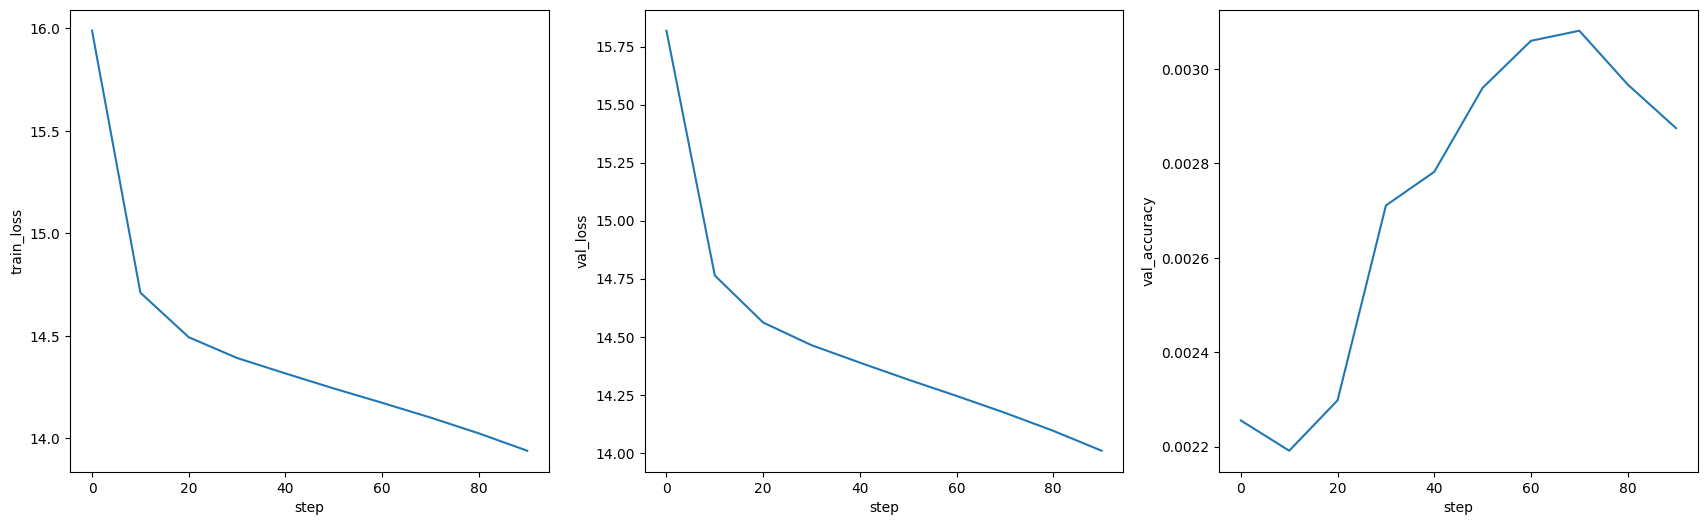

In [191]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')